In [1]:
#@title Setting up environment
from google.colab import output

!git clone https://github.com/Quiexx/SpaceFace.git

!pip install click requests tqdm pyspng imageio-ffmpeg==0.4.3

!pip uninstall torchvision -y
!pip uninstall torch -y
!pip install torchvision==0.4.2
!pip install torch==1.7.1

!pip install huggingface_hub

!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

%cd SpaceFace

output.clear()
print("Environment is set up")

Environment is set up


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
#@title Imports

import pickle
import torch
import PIL
import numpy as np
import torchvision.transforms as transforms
import math
import os
from huggingface_hub import hf_hub_download
import cv2
from IPython.display import HTML
from base64 import b64encode
from typing import List

def t2i(t):
  return PIL.Image.fromarray((t*127.5+127).clamp(0,255)[0].permute(1,2,0).cpu().numpy().astype('uint8'))

In [3]:
#@title Load network from huggingface

model_repo = "Quiexx/SpaceFace" #@param {type:"string"}
model_name = "space_face.pkl" #@param {type: "string"}

model_path = hf_hub_download(model_repo, model_name)

%cd stylegan2-ada-pytorch

with open(model_path, "rb") as f:
  model = pickle.load(f)

%cd ..

Downloading:   0%|          | 0.00/133M [00:00<?, ?B/s]

/content/SpaceFace/stylegan2-ada-pytorch
/content/SpaceFace


Seed: 3216877905852843512


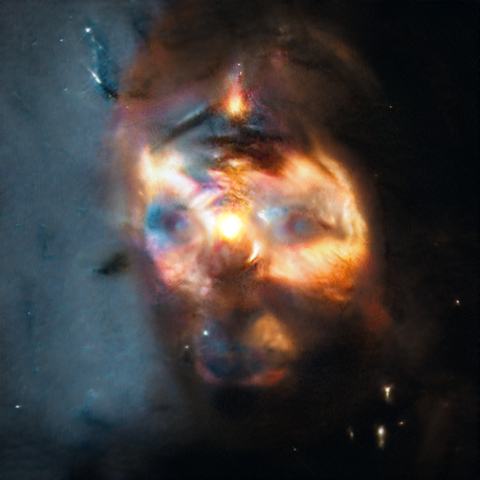

In [48]:
#@title Run model
#@markdown If seed is None, then torch.seed() is used

#@markdown Interesting seeds:

#@markdown 4626299924788034287

#@markdown 3216877905852843512


seed =  None#@param
if seed is None:
  seed = torch.seed()

torch.manual_seed(seed)

z = torch.randn([1, model.z_dim]).cuda() 
c = None 
w = model.mapping(z, c, truncation_psi=0.5, truncation_cutoff=8)
                           
img = model.synthesis(w, noise_mode='const', force_fp32=True)
print(f"Seed: {seed}")
display(t2i(img).resize((480, 480))) 

In [6]:
#@title Loading directions

eyes_open = torch.from_numpy(np.load('directions/eyes_open.npy').astype(np.float32)).cuda()
lip_ratio = torch.from_numpy(np.load('directions/lip_ratio.npy').astype(np.float32)).cuda()
pitch = torch.from_numpy(np.load('directions/pitch.npy').astype(np.float32)).cuda()
yaw = torch.from_numpy(np.load('directions/yaw.npy').astype(np.float32)).cuda()


In [7]:
#@title Loading psp

psp_repo = "Quiexx/SpaceFace"
psp_name = "psp_ffhq_encode.pt"
psp_path = hf_hub_download(psp_repo, psp_name)

%cd pixel2style2pixel

from argparse import Namespace
from models.psp import pSp

ckpt = torch.load(psp_path, map_location='cpu')
opts = ckpt['opts']

opts['checkpoint_path'] = psp_path
if 'learn_in_w' not in opts:
    opts['learn_in_w'] = False
if 'output_size' not in opts:
    opts['output_size'] = 1024

opts = Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

%cd ..

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

def mix_with_directions(source: torch.Tensor, directions: torch.Tensor, weights: float) -> torch.Tensor:
    latent = source.clone()
    for d, w in zip(directions, weights):
        latent += d * w
    latent += net.latent_avg.repeat(latent.shape[0], 1, 1)
    return latent

Downloading:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

/content/SpaceFace/pixel2style2pixel
Loading pSp from checkpoint: /root/.cache/huggingface/hub/bc578441b5a7706bcbdee80e2de6bd27bba51b2852abb6dafe65361306787ba6.732364b3903d8d5ed027abc5e4294d41aef29435cfe51dd2e29100ba6222c185
Model successfully loaded!
/content/SpaceFace


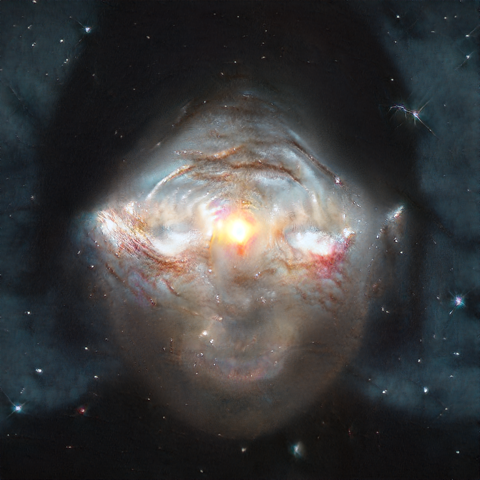

In [12]:
#@title Directions

w_eyes_open = -20 #@param {type:"slider", min:-20, max: 20, step:1}
w_lip_ratio = 0 #@param {type:"slider", min:-10, max: 10, step:1}
w_pitch = 0 #@param {type:"slider", min:-10, max: 10, step:1}
w_yaw = 0 #@param {type:"slider", min:-10, max: 10, step:1}

latent = mix_with_directions(w, [eyes_open, lip_ratio, pitch, yaw], [w_eyes_open, w_lip_ratio, w_pitch, w_yaw])

img = model.synthesis(latent, noise_mode='const', force_fp32=True)

img = t2i(img)
img.resize((480, 480))

In [30]:
#@title Create custom animation

save_path = "animation.mp4" #@param {type: "string"}

#@markdown ---
#@markdown Directions

#@markdown Open eyes:
open_eyes_from =  -30#@param {type: "number"}
open_eyes_to =  30#@param {type: "number"}

#@markdown Lip ratio:
lip_ratio_from =  0#@param {type: "number"}
lip_ratio_to =  0#@param {type: "number"}

#@markdown Pitch:
pitch_from =  0#@param {type: "number"}
pitch_to =  0#@param {type: "number"}

#@markdown Yaw:
yaw_from =  0#@param {type: "number"}
yaw_to =  0#@param {type: "number"}

#@markdown ---

duration =  4#@param {"type": "integer"}
fps = 30 #@param {type: "integer"}
loop = True #@param {"type": "boolean"}
if loop:
  duration /= 2
frame_count = int(fps * duration)

def to_mp4(frames: List[PIL.Image.Image], name: str, frame_count: int) -> str:
  if os.path.exists(name):
    os.remove(name)
  
  images = [cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR) for img in frames]
  height, width, layers = images[0].shape
  fourcc = cv2.VideoWriter_fourcc(*'MP4V')
  video = cv2.VideoWriter(name, fourcc, frame_count, (width, height))
  
  for image in images:
      video.write(image)

  video.release()
  video_h264_path = name.split(".")[-2] + "_h264.mp4"
  if os.path.exists(video_h264_path):
    os.remove(video_h264_path)

  os.system(f"ffmpeg -i {name} -vcodec libx264 {video_h264_path}")
  return video_h264_path

def show_mp4(video_path: str) -> None:
  mp4 = open(video_path, "rb").read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML(f"""
    <video width=400 controls>
        <source src="{data_url}" type="video/mp4">
    </video>
  """)

frames = []

open_eyes_step = (open_eyes_to - open_eyes_from) / frame_count
lip_ratio_step = (lip_ratio_to - lip_ratio_from) / frame_count
pitch_step = (pitch_to - pitch_from) / frame_count
yaw_step = (yaw_to - yaw_from) / frame_count


for frame_number in range(frame_count):
  w_eyes_open = open_eyes_from + frame_number * open_eyes_step
  w_lip_ratio = lip_ratio_from + frame_number * lip_ratio_step
  w_pitch = pitch_from + frame_number * pitch_step
  w_yaw = yaw_from + frame_number * yaw_step

  latent = mix_with_directions(w, [eyes_open, lip_ratio, pitch, yaw], [w_eyes_open, w_lip_ratio, w_pitch, w_yaw])

  img = model.synthesis(latent, noise_mode='const', force_fp32=True)
  img = t2i(img)

  frames.append(img)

if loop:
  frames.extend(frames[::-1])

to_show_path = to_mp4(frames, save_path, fps)


print("Animation created!")
show_mp4(to_show_path)


Animation created!


In [51]:
#@title Use prepared animations
#@markdown 1: looped horizontal rotation

#@markdown 2: looped horizontal and vertical rotation

#@markdown 3: rotation in a square

#@markdown 4: rotation in a circle

#@markdown 5: blinking


anim_type = "2" #@param [1, 2, 3, 4, 5]
save_path = "animation.mp4" #@param {type: "string"}
fps =  30#@param {"type": "integer"}
duration =  4#@param {"type": "integer"}
frame_count = fps * duration

def h_rotation():
  frames = []
  yaw_from =  -10
  yaw_to =  10
  yaw_step = (yaw_to - yaw_from) / (frame_count // 2)

  for frame_number in range(frame_count // 2):
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [yaw], [w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)


  frames.extend(frames[::-1])

  return frames

def h_v_rotation():
  pitch_from = -10
  pitch_to = 10

  yaw_from = -10
  yaw_to = 10
  yaw_step = (yaw_to - yaw_from) / (frame_count // 2)
  pitch_step = (pitch_to - pitch_from) / (frame_count // 2)
  
  frames = []

  for frame_number in range(frame_count // 2):
    w_yaw = yaw_from + frame_number * yaw_step
    w_pitch = pitch_from + frame_number * pitch_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)


  frames.extend(frames[::-1])

  return frames

def square_rotation():
  fc_stage = frame_count // 4

  frames = []

  # 1 stage
  pitch_from, pitch_to = -10, 10
  pitch_step = (pitch_to - pitch_from) / fc_stage

  w_yaw = -10

  for frame_number in range(fc_stage):
    w_pitch = pitch_from + frame_number * pitch_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  # 2 stage
  w_pitch = 10
  yaw_from, yaw_to = -10, 10
  yaw_step = (yaw_to - yaw_from) / fc_stage

  for frame_number in range(fc_stage):
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  # 3 stage
  pitch_from, pitch_to = 10, -10
  pitch_step = (pitch_to - pitch_from) / fc_stage

  w_yaw = 10

  for frame_number in range(fc_stage):
    w_pitch = pitch_from + frame_number * pitch_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  # 4 stage
  w_pitch = -10
  yaw_from, yaw_to = 10, -10
  yaw_step = (yaw_to - yaw_from) / fc_stage

  for frame_number in range(fc_stage):
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  return frames

def circle_rotation():
  fc_stage = frame_count // 4

  frames = []

  # 1 stage
  pitch_from, pitch_to = -10, 0
  pitch_step = (pitch_to - pitch_from) / fc_stage

  yaw_from, yaw_to = 0, -10
  yaw_step = (yaw_to - yaw_from) / fc_stage


  for frame_number in range(fc_stage):
    w_pitch = pitch_from + frame_number * pitch_step
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  # 2 stage
  pitch_from, pitch_to = 0, 10
  pitch_step = (pitch_to - pitch_from) / fc_stage
  
  yaw_from, yaw_to = -10, 0
  yaw_step = (yaw_to - yaw_from) / fc_stage

  for frame_number in range(fc_stage):
    w_pitch = pitch_from + frame_number * pitch_step
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  # 3 stage
  pitch_from, pitch_to = 10, 0
  pitch_step = (pitch_to - pitch_from) / fc_stage
  
  yaw_from, yaw_to = 0, 10
  yaw_step = (yaw_to - yaw_from) / fc_stage

  for frame_number in range(fc_stage):
    w_pitch = pitch_from + frame_number * pitch_step
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  # 4 stage
  pitch_from, pitch_to = 0, -10
  pitch_step = (pitch_to - pitch_from) / fc_stage
  
  yaw_from, yaw_to = 10, 0
  yaw_step = (yaw_to - yaw_from) / fc_stage

  for frame_number in range(fc_stage):
    w_pitch = pitch_from + frame_number * pitch_step
    w_yaw = yaw_from + frame_number * yaw_step

    latent = mix_with_directions(w, [pitch, yaw], [w_pitch, w_yaw])

    img = model.synthesis(latent, noise_mode='const', force_fp32=True)
    img = t2i(img)

    frames.append(img)

  return frames

def blinking():
  open_eyes_to = -30
  open_eyes_from = 30
  frames = []
  frames_per_stage = frame_count // 8

  open_eyes_step = (open_eyes_to - open_eyes_from) / frames_per_stage

  for stage in range(4):
    stage_frames = []
    for frame_number in range(frames_per_stage):
      w_eyes_open = open_eyes_from + frame_number * open_eyes_step

      latent = mix_with_directions(w, [eyes_open], [w_eyes_open])

      img = model.synthesis(latent, noise_mode='const', force_fp32=True)
      img = t2i(img)

      stage_frames.append(img)

    stage_frames.extend(stage_frames[::-1])
    frames.extend(stage_frames)
  return frames


anims = {"1": h_rotation, 
         "2": h_v_rotation, 
         "3": square_rotation, 
         "4": circle_rotation,
         "5": blinking}
         
frames = anims[anim_type]()
to_show_path = to_mp4(frames, save_path, fps)

print("Animation created!")
show_mp4(to_show_path)

Animation created!
